## Goal : Extract the evolution of the number of toggles for the project kops

Import

In [1]:
import os
import regex as re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import json

#### Before running the notebook

We extract all the versions of the featureflag/featureflag.go file with the answer of Nathan Arthur here : 
 https://stackoverflow.com/questions/12850030/git-getting-all-previous-version-of-a-specific-file-folder
 
We changed the directory to ../kops_change i.e. the line
 
 EXPORT_TO=/tmp/all_versions_exported
 
 becomes

 EXPORT_TO=../kops_changes/


#### If it worked, you should have a list of files in the ../kops_changes/ directory

### Now we can plot the number of feature toggles

In [2]:
kops_dir =  "../kops_changes/"

kops_files = [kops_dir+k for k in os.listdir(kops_dir)]

# 1. we count the number of FT

# we search for this type of expression (edit: not working for 2016-12-26): 
# New("DNSPreCreate", Bool(true)) 
# because each time it is in the code, a feature toggle is defined 
# NB : 'Bool' because this part is not in the definition of the constructor New
# we are sure to only count the feature toggles
exp = "[N|n]ew.*,*Bool*"

def extract_nb_ft(file_path):
    # input : a file path to a version of the feature toggle file
    # output : the number of feature toggles in the file
    with open(file_path, 'r') as f:
        m = re.findall(exp, f.read())
    return len(m)

# 2. we extract the date (usable as timestamp)

def extract_date(file_path):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : the date "26-Oct-2021"
    return file_path.split(".")[3]

months = dict()

writen_monthes = pd.Series([extract_date(kf).split('-')[1] for kf in kops_files]).unique()
# writen_monthes
# ['Jun', 'Oct', 'Sep', 'May', 'Jan', 'Aug', 'Dec', 'Apr', 'Jul', 'Feb', 'Nov', 'Mar']
values = [6, 10, 9, 5, 1, 8, 12, 4, 7, 2, 11, 3]

for index_month in range(len(writen_monthes)):
    wm = writen_monthes[index_month]
    months[wm] = values[index_month]

def extract_stamp(kf):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : a timestamp
    d = extract_date(kf).split('-')
    # class datetime.date(year, month, day)
    return datetime.date(int(d[2]), months[d[1]], int(d[0]))

# test 1. and 2. with a randomly chosen file
kf = kops_files[np.random.randint(len(kops_files))]

print("File :",kf)
print("Stamp :",extract_stamp(kf))
print("Number of FTs :",extract_nb_ft(kf))

File : ../kops_changes/0076.12-May-2021.7112dada3cb9cccd58678a2d5d80537577f0e754.featureflag.go
Stamp : 2021-05-12
Number of FTs : 24


In [3]:
df_ft = pd.DataFrame([[extract_stamp(kf) for kf in kops_files], 
                  [extract_nb_ft(kf) for kf in kops_files]]).transpose()
df_ft.columns = ["Date", "#FTs"]
df_ft = df_ft.sort_values(by=["Date"])

### Add releases & tags

We download the releases of kops thanks to postman and store them in a file ../kops_releases.json:

call https://api.github.com/repos/kubernetes/kops/releases

?per_page=100&page=1

and

?per_page=100&page=2

In [4]:
releases = json.load(open("../kops_releases.json"))

date_release = [datetime.datetime.strptime(r["published_at"], "%Y-%m-%dT%H:%M:%SZ")
                for r in releases]
name_release = [r["name"] for r in releases]

df_rel = pd.DataFrame([date_release, name_release]).transpose()
df_rel.columns = ["Date", "Name"]

for i in range(df_rel.shape[0]):
    name = df_rel['Name'][i]
    if name[0]!='v':
        df_rel['Name'][i]='v'+df_rel['Name'][i]

df_rel["short"] = [k.split(".")[0]+'.'+k.split('.')[1] for k in df_rel['Name']]

df_rel = df_rel.sort_values(by=["short","Date"])

short_names = pd.Series([k.replace(" ", "") for k in df_rel["short"]]).unique()
short_dates = df_rel.groupby(['short']).min()['Date']

<ipython-input-4-1eeb600067bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['Name'][i]='v'+df_rel['Name'][i]


In [5]:
len(releases)

131

#### Plot results

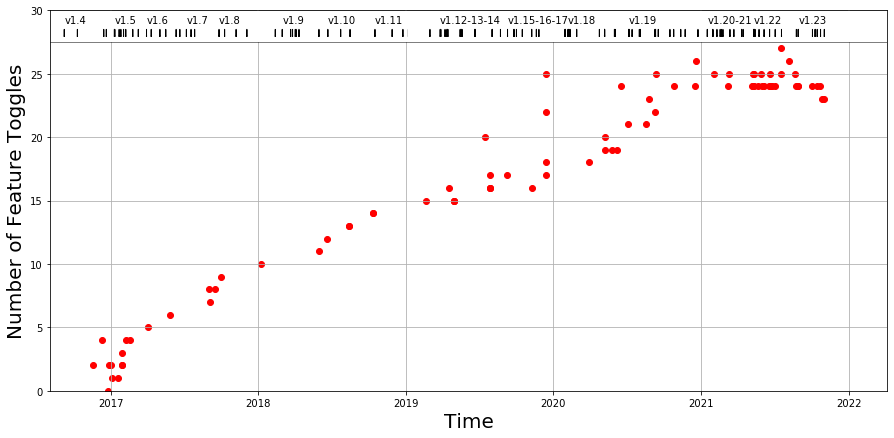

In [15]:
fig, ax = plt.subplots(figsize=((15, 7)))

ax.grid(zorder = 0)
ax.scatter(df_ft["Date"], df_ft["#FTs"], color = "red", zorder = 0)

for year in range(2017, 2023):
    plt.vlines(x = datetime.date(year, 1, 1), ymin = 27.5, ymax = 35, color = "white", linewidth = 2)

for index_release in range(len(df_rel)):
    ax.arrow(df_rel["Date"][index_release], 28.5, 0, -0.5, head_width=0.5, head_length=0.1)

hide_me = ['v1.13', 'v1.14', 'v1.16', 'v1.17', 'v1.21']
replace_me = dict()
replace_me['v1.12'] = "v1.12-13-14"
replace_me['v1.15'] = "v1.15-16-17"
replace_me['v1.20'] = "v1.20-21"

for sn in short_names:
    if sn not in replace_me:
        if sn not in hide_me:
            ax.text(short_dates[sn], 29, sn, size = 10)
    else:
        ax.text(short_dates[sn], 29, replace_me[sn], size = 10)


plt.axhline(y = 27.5, color = "black", linewidth = 0.5)

plt.ylim(0, 30)
plt.ylabel("Number of Feature Toggles", size = 20)
plt.xlabel("Time", size = 20)
plt.savefig("../evolution_fts_kops.png", dpi = 300)
plt.show()

In [30]:
dates = [r["published_at"] for r in releases]
commits = [r["target_commitish"] for r in releases]

df_commit = pd.DataFrame([dates, commits]).transpose()
df_commit.columns = ["Date", "Commit"]

for year in range(2017, 2022):
    df = df_commit[df_commit["Date"].str.contains(str(year), na=False)]
    print(df['Date'].iloc[np.argmin(df["Date"])], df['Commit'].iloc[np.argmin(df["Date"])])

2017-01-10T04:33:19Z c72ef959b710612855fe4a03460d2bbd9d38fd7d
2018-02-12T03:38:28Z 94ef2027bed84f7335b5f3aa37f3fec99eb04089
2019-01-02T22:09:10Z 2c204246567cebcb5badf11550cc2778aa9b79a9
2020-01-29T16:01:33Z 5db135e3bd4e66e1c5e9301914fc7c33eed7f4a7
2021-01-15T15:37:34Z 6b538c395c9acaa3a472a634dad1ff651e3a375d
